# RNN, LSTM, And GRU For Trading

# Importing Libraries

In [61]:
import numpy as np
import pandas as pd
import math
import datetime as dt
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
#Files
from util import fetchOnlineData, slice_df

# Initial variables

In [62]:
symbol = "AABA"

# We'll look back 365 days
start_d = dt.date.today() - dt.timedelta(365)

# Importing dataset

In [63]:
yesterday = dt.date.today() - dt.timedelta(1)
dataset = fetchOnlineData(start_d, symbol, yesterday, del_cols=False)

[*********************100%***********************]  1 of 1 downloaded


In [118]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-29,80.000000,80.430000,78.970001,79.339996,79.339996,9719600
2018-01-30,77.580002,79.269997,76.760002,78.269997,78.269997,7326500
2018-01-31,79.000000,80.559998,79.000000,79.879997,79.879997,6639200
2018-02-01,76.480003,78.360001,75.690002,76.010002,76.010002,8098000
2018-02-02,76.449997,76.699997,74.169998,74.400002,74.400002,8327000


In [119]:
df_stock = dataset.copy()
df_stock = df_stock.dropna()
df_stock = df_stock[['Open', 'High', 'Low', 'Close']]

# Data scaling

In [120]:
# data scaling (normalizing)
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# Splitting dataset

In [121]:
# Splitting the dataset into Train, Valid & test data 
valid_set_size_percentage = 10 
test_set_size_percentage = 10 
seq_len = 20 # taken sequence length as 20
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() 
    data = [] 
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (184, 19, 4)
y_train.shape =  (184, 4)
x_valid.shape =  (23, 19, 4)
y_valid.shape =  (23, 4)
x_test.shape =  (23, 19, 4)
y_test.shape =  (23, 4)


/home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


# Building the model

In [122]:
# parameters & Placeholders 
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

## Function to get the next batch

In [123]:

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size 
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size     
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

## Layers

In [124]:
#RNN 
#layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#         for layer in range(n_layers)]
# LSTM  
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#         for layer in range(n_layers)]

#LSTM with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

#GRU 
layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
        for layer in range(n_layers)] 


In [125]:
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

## Cost function

In [126]:
# Cost function
loss = tf.reduce_mean(tf.square(outputs - y))

## Optimizer

In [127]:
#optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

## Fitting the model

In [137]:
# Fitting the model
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    print("Training model...")
    print("MSE (on training data):")
    training_mse = []
    validation_mse = []
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(iteration*batch_size/train_set_size, mse_train, mse_valid))
            # Add the loss metrics from this period to our list.
            training_mse.append(mse_train)
            validation_mse.append(mse_valid)
    print("Model training finished.")
    # Predictions
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})            

Training model...
MSE (on training data):
0.00 epochs: MSE train/valid = 0.393198/0.084995
4.89 epochs: MSE train/valid = 0.170386/0.039078
9.78 epochs: MSE train/valid = 0.018233/0.009190
14.67 epochs: MSE train/valid = 0.015308/0.008924
19.57 epochs: MSE train/valid = 0.013419/0.008356
24.46 epochs: MSE train/valid = 0.012713/0.008338
29.35 epochs: MSE train/valid = 0.012454/0.008270
34.24 epochs: MSE train/valid = 0.012230/0.008245
39.13 epochs: MSE train/valid = 0.011993/0.008206
44.02 epochs: MSE train/valid = 0.011732/0.008158
48.91 epochs: MSE train/valid = 0.011476/0.008111
53.80 epochs: MSE train/valid = 0.011213/0.008067
58.70 epochs: MSE train/valid = 0.010926/0.008008
63.59 epochs: MSE train/valid = 0.010632/0.007941
68.48 epochs: MSE train/valid = 0.010322/0.007881
73.37 epochs: MSE train/valid = 0.009992/0.007805
78.26 epochs: MSE train/valid = 0.009633/0.007732
83.15 epochs: MSE train/valid = 0.009281/0.007667
88.04 epochs: MSE train/valid = 0.008913/0.007544
92.93 epoch

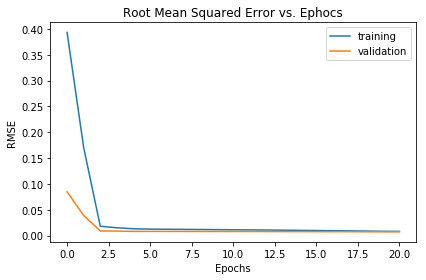

In [144]:
# Output a graph of loss metrics over periods.
plt.ylabel("RMSE")
plt.xlabel("Epochs")
plt.title("Root Mean Squared Error vs. Ephocs")
plt.tight_layout()
plt.plot(training_mse, label="training")
plt.plot(validation_mse, label="validation")
plt.legend()

#print("Final RMSE (on training data):   %0.2f" % training_mse)
#print("Final RMSE (on validation data): %0.2f" % validation_mse)


# Predictions

In [129]:
# Shaping prediction output
y_test_pred.shape

(23, 4)

## Standarized data and predictions

In [130]:
real_prediction = min_max_scaler.inverse_transform(y_test_pred)
real_price = min_max_scaler.inverse_transform(y_test)

# Plotting the graph

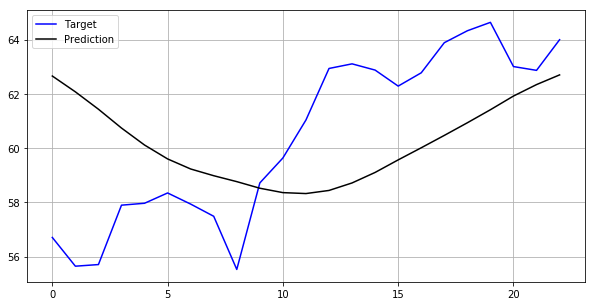

In [131]:
# ploting the graph
comp = pd.DataFrame({'Real price':real_price[:,3],'Prediction':real_prediction[:,3]})
plt.figure(figsize=(10,5))
plt.plot(comp['Real price'], color='blue', label='Target')
plt.plot(comp['Prediction'], color='black', label='Prediction')
plt.legend()
plt.grid()
plt.show()

## Results

In [132]:
mse = metrics.mean_squared_error(y_test, y_test_pred)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))


Mean Squared Error: 0.01455436379637543
